In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix


%matplotlib inline

In [2]:
tops=pd.read_csv(r'D:\prbtops_inhouse.csv')
small=tops.head()

In [3]:
tops.head()

,api,formation,source,depth
0,4902706165,NIOBRARA,RL,238.13464
1,4902706165,POOL_CREEK,RL,821.76333
2,4902706165,GREENHORN,RL,977.24422
3,4902706165,BELLE_FOURCHE,RL,1110.03337
4,4902706165,SAGE_BREAKS,AF,441.34139


In [110]:
data=np.asarray(tops[['api', 'formation', 'depth']])
tops['depth'].max()

19738.11565

In [112]:
D_df = tops.pivot_table('depth', 'formation', 'api').fillna(0)

In [113]:
R =D_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [6]:
n_wells = tops.api.unique().shape[0]
n_formations = tops.formation.unique().shape[0]

print('Number of wells: {}'.format(n_wells))
print('Number of formations: {}'.format(n_formations))
print('Sparsity: {:4.3f}%'.format(float(tops.shape[0]) / float(n_wells*n_formations) * 100))

Number of wells: 2349
Number of formations: 44
Sparsity: 28.501%


In [7]:
formation_to_idx = {}
idx_to_formation = {}
for (idx, formation) in enumerate(tops.formation.unique().tolist()):
    formation_to_idx[formation] = idx
    idx_to_formation[idx] = formation
    
api_to_idx = {}
idx_to_api = {}
for (idx, api) in enumerate(tops.api.unique().tolist()):
    api_to_idx[api] = idx
    idx_to_api[idx] = api

In [8]:
def map_ids(row, mapper):
    return mapper[row]
import scipy.sparse as sparse


In [9]:
#%%timeit
J = tops.api.apply(map_ids, args=[api_to_idx]).as_matrix()
I = tops.formation.apply(map_ids, args=[formation_to_idx]).as_matrix()
V = tops.depth.astype(int)#/max(tops.depth.astype(int))
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

In [10]:
print('Number of data points: {}'.format(n_wells*n_formations))

Number of data points: 103356


In [135]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 10)
sigma = np.diag(sigma)


In [136]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = D_df.columns, index=D_df.index)

In [137]:
preds_df.iloc[0:,1]

formation
2ND_WALL_CREEK          -591.990128
3RD_WALL_CREEK           491.348654
4TH_WALL_CREEK           173.246104
ARDMORE_BENTONITE        105.159048
BELLE_FOURCHE           8411.603456
CARLILE                  646.281160
EMIGRANT_GAP             914.286340
FOX_HILLS               3176.495325
GAMMON                  1397.798327
GREENHORN               8317.908322
KARA_BENTONITE            18.920002
KARA_BENTONITE_BASE       19.368324
LOWER_BELLE_SAND         -92.018764
MITTEN_BLACK_SHALE      5606.097936
MOWRY                   8842.965161
MUDDY                   7033.400641
NIOBRARA                7612.184579
NIOBRARA_A              3301.256290
NIOBRARA_B              6247.820394
NIOBRARA_C              6424.666254
PARKMAN/HYGIENE          455.651701
PARKMAN/HYGIENE_BASE     436.436741
PARKMAN_BASE            -791.376344
PARKMAN_BTM               -9.202775
PARKMAN_TOP             -875.978157
PIERRE                  3448.521288
POOL_CREEK              6372.626899
RED_BIRD          

In [138]:
D_df.iloc[0:,1]

formation
2ND_WALL_CREEK             0.00000
3RD_WALL_CREEK             0.00000
4TH_WALL_CREEK             0.00000
ARDMORE_BENTONITE          0.00000
BELLE_FOURCHE           7871.02322
CARLILE                    0.00000
EMIGRANT_GAP               0.00000
FOX_HILLS               3891.48955
GAMMON                     0.00000
GREENHORN               7651.65506
KARA_BENTONITE          4519.06062
KARA_BENTONITE_BASE     4610.00000
LOWER_BELLE_SAND           0.00000
MITTEN_BLACK_SHALE      5405.74345
MOWRY                   8410.48458
MUDDY                   8595.39625
NIOBRARA                6966.43878
NIOBRARA_A                 0.00000
NIOBRARA_B              7071.17160
NIOBRARA_C              7205.00000
PARKMAN/HYGIENE            0.00000
PARKMAN/HYGIENE_BASE       0.00000
PARKMAN_BASE               0.00000
PARKMAN_BTM                0.00000
PARKMAN_TOP                0.00000
PIERRE                  4023.00000
POOL_CREEK              7602.08783
RED_BIRD                5131.21609
SAGE_BREAK

In [32]:
import implicit

In [150]:
model = implicit.als.AlternatingLeastSquares(factors=30)

In [151]:
model.fit(likes)

In [152]:
user_items = likes.T.tocsr()

In [153]:
recommendations = model.recommend(0, user_items)

In [154]:
likes

<442x2861 sparse matrix of type '<class 'numpy.float64'>'
	with 14804 stored elements in Compressed Sparse Row format>

In [155]:
recommendations

[(57, 0.8961089),
 (10, 0.8462074),
 (9, 0.83976054),
 (8, 0.79854),
 (22, 0.79053617),
 (244, 0.65557694),
 (11, 0.64325),
 (119, 0.63639545),
 (36, 0.5614818),
 (120, 0.55520636)]

In [147]:
likes.T.tocsr().todense()[0]
np.mean([9285.,  9760., 11227., 11793., 12139., 12477.])

11113.5

In [127]:
tops[tops['api']==3521913]

,api,formation,depth,ssdepth
0,3521913,WASATCH,0,7281
1,3521913,LANCE,9285,-2004
2,3521913,JONAH,11227,-3946
3,3521913,YELLOWPOINT,11793,-4512
4,3521913,WARDELL,12139,-4858
5,3521913,MESAVERDE,12477,-5196


In [159]:
tops.formation.unique()[22]

'TD'

In [169]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
  

In [170]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [172]:
MF_ALS = ExplicitMF(likes, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]


In [145]:
from sklearn.preprocessing import binarize
A=binarize(R)

In [142]:
def runALS(A, R, n_factors, n_iterations, lambda_):
    '''
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    '''
    print("Initiating ")
    lambda_ = 0.1; n_factors = 3; n, m = A.shape; n_iterations = 20
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(np.dot(Items, np.dot(np.diag(Ri), Items.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(Items, np.dot(np.diag(Ri), A[i].T))).T
        print("Error after solving for User Matrix:", get_error(A, Users, Items, R))

        for j, Rj in enumerate(R.T):
            Items[:,j] = np.linalg.solve(np.dot(Users.T, np.dot(np.diag(Rj), Users)) + lambda_ * np.eye(n_factors),
                                     np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])))
        print("Error after solving for Item Matrix:", get_error(A, Users, Items, R))

        MSE_List.append(get_error(A, Users, Items, R))
        print('%sth iteration is complete...' % iter)

    print(MSE_List)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    plt.savefig('Python MSE Graph.pdf', format='pdf')
    plt.show()

Initiating 
Starting Iterations
Error after solving for User Matrix: 10982876.04027309
Error after solving for Item Matrix: 601444.0752039407
0th iteration is complete...
Error after solving for User Matrix: 205049.34629625248
Error after solving for Item Matrix: 89365.86535064637
1th iteration is complete...
Error after solving for User Matrix: 55593.001024434074
Error after solving for Item Matrix: 33014.225623939106
2th iteration is complete...
Error after solving for User Matrix: 21113.927966812684
Error after solving for Item Matrix: 14746.971725372898
3th iteration is complete...
Error after solving for User Matrix: 12340.351750053851
Error after solving for Item Matrix: 10685.041212430087
4th iteration is complete...
Error after solving for User Matrix: 9655.834687601524
Error after solving for Item Matrix: 8840.936985969993
5th iteration is complete...
Error after solving for User Matrix: 8206.848270209328
Error after solving for Item Matrix: 7645.719645013711
6th iteration is 

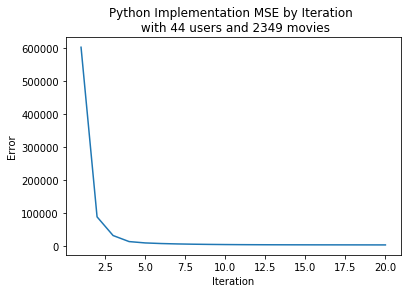

In [149]:
runALS(R, A, 10, 2, 1)